<a href="https://colab.research.google.com/github/maneshnambiar/ai-pneumonia-detection/blob/master/Pneumonia_YOLO_APPROACH_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [0]:
!pip install pydicom

In [0]:
random_stat = 123
np.random.seed(random_stat)

In [0]:
!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

fatal: destination path 'darknet' already exists and is not an empty directory.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~


In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-05-03 06:00:44--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  2.76MB/s    in 45s     

2020-05-03 06:01:30 (3.42 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [0]:
DATA_DIR = '/content'

train_dcm_dir = os.path.join(DATA_DIR, '/content/drive/My Drive/stage_2_train_images/IMG/IMG')
test_dcm_dir = os.path.join(DATA_DIR, '/content/drive/My Drive/stage_2_test_images/stage_2_test_images')

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [0]:
!ls -shtl

total 158M
620K drwxr-xr-x  2 root root 616K May  3 05:51 images
4.0K drwxr-xr-x  2 root root 4.0K May  3 05:38 metadata
392K drwxr-xr-x  2 root root 388K May  3 05:05 labels
4.0K drwx------  4 root root 4.0K May  3 04:35 drive
4.0K drwxr-xr-x  2 root root 4.0K May  3 04:34 backup
4.0K drwxr-xr-x  2 root root 4.0K May  3 04:34 cfg
1.9M -rwxr-xr-x  1 root root 1.9M May  3 04:31 darknet_gpu
4.0K drwxr-xr-x 13 root root 4.0K May  3 04:31 darknet
4.0K drwxr-xr-x  1 root root 4.0K Apr  3 16:24 sample_data
155M -rw-r--r--  1 root root 155M Mar 25  2018 darknet53.conv.74


In [0]:
import pandas as pd
annots  = pd.read_csv('/content/drive/My Drive/stage_2_train_labels.csv', header=0, sep=',', quotechar='"')

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [0]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

Streaming output truncated to the last 5000 lines.
 58%|█████▊    | 17387/30227 [12:58<09:02, 23.66it/s]

 58%|█████▊    | 17391/30227 [12:58<09:16, 23.06it/s]

 58%|█████▊    | 17397/30227 [12:58<09:01, 23.70it/s]

 58%|█████▊    | 17400/30227 [12:58<10:16, 20.82it/s]

 58%|█████▊    | 17404/30227 [12:59<11:39, 18.34it/s]

 58%|█████▊    | 17407/30227 [12:59<13:29, 15.84it/s]

 58%|█████▊    | 17410/30227 [12:59<13:17, 16.06it/s]

 58%|█████▊    | 17412/30227 [12:59<17:56, 11.91it/s]

 58%|█████▊    | 17415/30227 [12:59<17:35, 12.14it/s]

 58%|█████▊    | 17418/30227 [13:00<16:08, 13.23it/s]

 58%|█████▊    | 17424/30227 [13:00<13:13, 16.14it/s]

 58%|█████▊    | 17427/30227 [13:00<14:08, 15.08it/s]

 58%|█████▊    | 17430/30227 [13:00<14:16, 14.93it/s]

 58%|█████▊    | 17433/30227 [13:01<18:09, 11.75it/s]

 58%|█████▊    | 17435/30227 [13:01<17:38, 12.09it/s]

 58%|█████▊    | 17437/30227 [13:01<18:38, 11.44it/s]

 58%|█████▊    | 17439/30227 [13:01<17:49, 11.95it/s]

 58%|█████▊   

In [0]:
!du -sh images labels


990M	images
24M	labels


0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



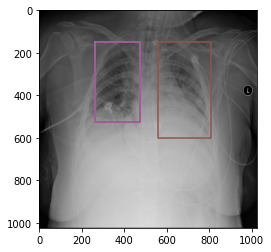

In [0]:
#Plot a sample train image and label
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [0]:
#Generate train/val file path list (.txt)
#We should give the list of image paths to YOLO. two seperate list textfiles for training images and validation images.
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [0]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


In [0]:
#Create test image and labels for YOLOv3
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)


In [0]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

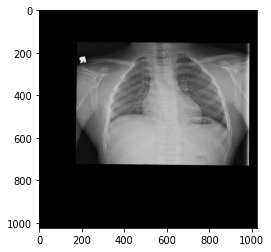

In [0]:
#Plot a sample test Image
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

In [0]:
#Prepare Configuration Files for Using YOLOv3
#We should prepare and modify config files, and bring pre-trained weights necessary for training. This proceeds with following four steps.


NameError: ignored

In [0]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [0]:
!cat cfg/rsna.data

classes= 1
train  = /content/metadata/tr_list.txt
valid  = /content/metadata/val_list.txt
names  = /content/cfg/rsna.names
backup = /content/backup
    

In [0]:
# Label list of bounding box.
!echo "pneumonia" > cfg/rsna.names

In [0]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

In [0]:
# Training YOLOv3

In [0]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1OhnlV3s7r6xsEme6DKkNYjcYjsl-C_Av" -O train_log.txt

(0.0, 4.05)

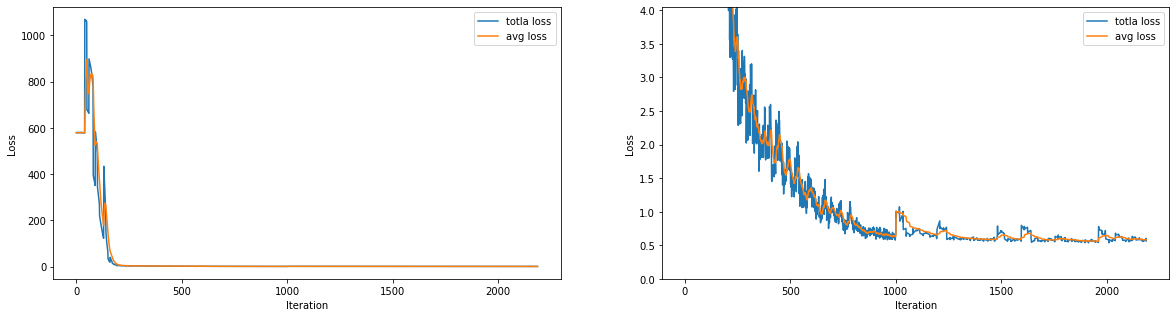

In [0]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])

In [0]:
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


In [0]:
#Load trained model (at 15300 iteration)

In [0]:
#Load trained model (at 15300 iteration)
#Since i uploaded the weights file (large big file) on my google drive, the command is very very long ...

#It's a weight file at 15300 iteration, which I made submission file with. If you use this weight, you'll get a score of 0.141LB.
#Up to 15300 iteration, It takes about 8 hours.
#In .cfg file, I set 'batch' and 'subdivisions' as 64 and 8 respectively.
#Up to 1000 iteration from 0, it takes about 1h with one Tesla P100 GPU. (1000 iter/h)
#Up to 15300 iteration from 1000, it takes about 7h with four Tesla P100 GPU. (2043 iter/h)

In [0]:

!wget --load-cookies /tmp/cookies.txt -q "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd" -O backup/rsna_yolov3_15300.weights && rm -rf /tmp/cookies.txt

In [0]:
!ls -alsth backup

total 235M
235M -rw-r--r-- 1 root root 235M May  3 07:35 rsna_yolov3_15300.weights
4.0K drwxr-xr-x 2 root root 4.0K May  3 07:35 .
4.0K drwxr-xr-x 1 root root 4.0K May  3 06:13 ..


In [0]:
#Cfg File for testing 
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

In [0]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../test.jpg -thresh 0.005

CUDA Error: no CUDA-capable device is detected
darknet: ./src/cuda.c:36: check_error: Assertion `0' failed.


TypeError: ignored

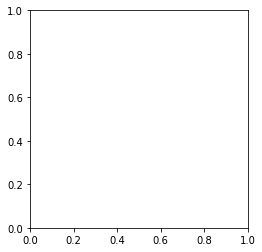

In [0]:
# ![](predictions.jpg)
plt.imshow(cv2.imread("./darknet/predictions.jpg"))